In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pprint import pprint
import nltk
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim   
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim  
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
news=pd.read_csv('abcnews_date_text1.csv')

In [3]:
# Convert to list
news_data = news.headline_text.values.tolist()

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [5]:
# Tokenize words and preprocess text
news_words=[gensim.utils.simple_preprocess(str(sentence), deacc=True) for sentence in news_data]# deacc=True removes punctuations

In [6]:
print(news_words[:1])

[['aba', 'decides', 'against', 'community', 'broadcasting', 'licence']]


In [7]:
import warnings
warnings.filterwarnings("ignore")
# Build the bigram and trigram models
bigram = gensim.models.Phrases(news_words, min_count=3, threshold=10)  
trigram = gensim.models.Phrases(bigram[news_words], threshold=10) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[news_words[0]]])

['aba', 'decides', 'against', 'community', 'broadcasting', 'licence']


In [8]:
news_words_nostops= [[word for word in simple_preprocess(str(news)) if word not in stop_words] for news in news_words]

In [9]:
# Form Bigrams
news_words_trigrams= [trigram_mod[news] for news in news_words_nostops]

In [10]:
print(news_words_trigrams[0])

['aba', 'decides', 'community', 'broadcasting', 'licence']


In [11]:
# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
# Instantiate the WordNetLemmatizer
wordnet_lemmatizer =WordNetLemmatizer()

# Lemmatize all tokens into a new list: lemmatized
lemmatized = [[wordnet_lemmatizer.lemmatize(t) for t in news] for news in news_words_trigrams]
print(lemmatized[:1])

[['aba', 'decides', 'community', 'broadcasting', 'licence']]


In [11]:
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
lemmatized=[[token.lemma_ for token in nlp(" ".join(news)) if token.pos_ in allowed_postags] for news in news_words_trigrams]
print(lemmatized[:1])

[['aba', 'decide', 'community', 'broadcasting', 'licence']]


In [12]:
# Create the Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(lemmatized)

# Create Corpus
news_texts = lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(news) for news in news_texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in corp] for corp in corpus[:1]]

[[('aba', 1),
  ('broadcasting', 1),
  ('community', 1),
  ('decide', 1),
  ('licence', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"find" + 0.026*"call" + 0.025*"kill" + 0.020*"continue" + '
  '0.019*"death" + 0.017*"law" + 0.013*"begin" + 0.010*"bus" + 0.010*"gas" + '
  '0.010*"woman"'),
 (1,
  '0.050*"iraqi" + 0.028*"get" + 0.027*"take" + 0.022*"help" + 0.014*"hold" + '
  '0.013*"case" + 0.012*"election" + 0.012*"keep" + 0.012*"consider" + '
  '0.012*"lead"'),
 (2,
  '0.051*"sar" + 0.038*"say" + 0.027*"report" + 0.016*"syria" + 0.015*"stop" + '
  '0.013*"offer" + 0.013*"dead" + 0.013*"china" + 0.011*"name" + '
  '0.011*"remain"'),
 (3,
  '0.063*"iraq" + 0.025*"fire" + 0.014*"fight" + 0.013*"make" + 0.013*"start" '
  '+ 0.012*"work" + 0.012*"murder" + 0.012*"put" + 0.011*"pm" + 0.011*"aid"'),
 (4,
  '0.028*"win" + 0.020*"hospital" + 0.018*"concern" + 0.014*"protest" + '
  '0.014*"support" + 0.013*"probe" + 0.012*"first" + 0.012*"centre" + '
  '0.012*"health" + 0.012*"aust"'),
 (5,
  '0.019*"still" + 0.018*"charge" + 0.017*"road" + 0.017*"miss" + '
  '0.016*"victim" + 0.015*"ban" + 0.015*"open" + 0.0

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.569860570810034

Coherence Score:  0.6286647999509384


In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      10.915281        1       1  0.038013  0.060355
3      10.681701        1       2  0.037344  0.036738
6      10.632040        1       3 -0.348172 -0.033394
7      10.396812        1       4  0.048355  0.106987
5      10.360696        1       5  0.077473 -0.329511
9       9.945665        1       6  0.043630  0.055664
2       9.595583        1       7  0.022945  0.031705
0       9.335655        1       8  0.027594  0.024109
8       9.216428        1       9  0.025149  0.027651
1       8.920139        1      10  0.027670  0.019696, topic_info=     Category        Freq      Term       Total  loglift  logprob
term                                                             
40    Default  393.000000      iraq  393.000000  30.0000  30.0000
6539  Default  287.000000       sar  287.000000  29.0000  29.0000
424   Default  276.000000       new  276.000000  28.0000  28.0000
166   Default  258.000000     iraqi  258.000000  27.0000  27.0000
513   Default  274.000000    police  274.000000  26.0000  26.0000
3272  Default  238.000000   baghdad  238.000000  25.0000  25.0000
307   Default  234.000000       man  234.000000  24.0000  24.0000
56    Default  224.000000      plan  224.000000  23.0000  23.0000
453   Default  211.000000       say  211.000000  22.0000  22.0000
39    Default  197.000000   council  197.000000  21.0000  21.0000
410   Default  192.000000     claim  192.000000  20.0000  20.0000
89    Default  182.000000      urge  182.000000  19.0000  19.0000
26    Default  178.000000       win  178.000000  18.0000  18.0000
477   Default  168.000000      face  168.000000  17.0000  17.0000
183   Default  165.000000      govt  165.000000  16.0000  16.0000
417   Default  147.000000       get  147.000000  15.0000  15.0000
74    Default  149.000000    report  149.000000  14.0000  14.0000
492   Default  155.000000       may  155.000000  13.0000  13.0000
52    Default  142.000000      take  142.000000  12.0000  12.0000
8     Default  153.000000      fire  153.000000  11.0000  11.0000
305   Default  144.000000      find  144.000000  10.0000  10.0000
11    Default  142.000000      call  142.000000   9.0000   9.0000
610   Default  138.000000      kill  138.000000   8.0000   8.0000
247   Default  124.000000      back  124.000000   7.0000   7.0000
407   Default  127.000000  hospital  127.000000   6.0000   6.0000
272   Default  115.000000     group  115.000000   5.0000   5.0000
46    Default  121.000000       war  121.000000   4.0000   4.0000
127   Default  113.000000      help  113.000000   3.0000   3.0000
207   Default  118.000000     still  118.000000   2.0000   2.0000
159   Default  111.000000  continue  111.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
166   Topic10  257.318623     iraqi  258.113052   2.4138  -3.0053
417   Topic10  146.608265       get  147.402726   2.4115  -3.5678
52    Topic10  141.402031      take  142.196518   2.4113  -3.6040
127   Topic10  112.443289      help  113.237756   2.4098  -3.8331
165   Topic10   75.267365      hold   76.061817   2.4064  -4.2345
331   Topic10   68.826954      case   69.621421   2.4054  -4.3240
1114  Topic10   63.042227  election   63.836728   2.4043  -4.4118
1248  Topic10   62.523706      keep   63.318354   2.4042  -4.4200
332   Topic10   60.527604  consider   61.322068   2.4038  -4.4525
84    Topic10   60.272362      lead   61.066756   2.4038  -4.4567
1249  Topic10   59.864880      play   60.659510   2.4037  -4.4635
5435  Topic10   57.747529  us_force   58.541975   2.4032  -4.4995
789   Topic10   50.963320   funding   51.757853   2.4014  -4.6245
415   Topic10   50.840945     clear   51.635393   2.4014  -4.6269
204   Topic10   50.121069      cost   50.915568   2.4011  -4.6411
838   Topic10   49.677643      fear   50.472061   2.4010  -4.6500
2367  Topic10   47.094520      jone   47.889202   2.4001  -4.7034
903   Top

In [26]:
### Building LDA Mallet Model
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [27]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('police', 0.025711662075298437),
   ('man', 0.02194674012855831),
   ('govt', 0.014325068870523415),
   ('charge', 0.013682277318640955),
   ('face', 0.01349862258953168),
   ('court', 0.011937557392102846),
   ('hospital', 0.010651974288337925),
   ('find', 0.010560146923783287),
   ('sar', 0.010284664830119375),
   ('ban', 0.010009182736455464)]),
 (1,
  [('claim', 0.01910480349344978),
   ('council', 0.018377001455604076),
   ('fire', 0.017194323144104802),
   ('urge', 0.012281659388646287),
   ('back', 0.012008733624454149),
   ('continue', 0.011917758369723435),
   ('set', 0.011008005822416303),
   ('concern', 0.009734352256186317),
   ('water', 0.009734352256186317),
   ('open', 0.008915574963609897)]),
 (2,
  [('plan', 0.02463321861981525),
   ('win', 0.020105053432349213),
   ('nsw', 0.011139286361166456),
   ('rain', 0.010052526716174607),
   ('boost', 0.009780836804926644),
   ('lead', 0.009599710197428002),
   ('australia', 0.009146893678681399),
   ('group', 0.0091

# LSI Model

In [37]:
from gensim.models import LsiModel

# Build the LSI Model
lsi_model = LsiModel(corpus=corpus, id2word=id2word, num_topics=2, decay=0.5)

# View Topics
pprint(lsi_model.print_topics(-1))

[(0,
  '-0.890*"iraq" + -0.235*"say" + -0.202*"war" + -0.070*"iraqi" + '
  '-0.068*"plan" + -0.063*"new" + -0.055*"missile" + -0.049*"pm" + '
  '-0.049*"report" + -0.048*"baghdad"'),
 (1,
  '0.423*"police" + 0.419*"new" + 0.331*"plan" + -0.315*"iraq" + 0.237*"war" + '
  '0.214*"man" + 0.199*"iraqi" + 0.128*"say" + 0.118*"claim" + '
  '0.113*"council"')]


In [38]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('\nCoherence Score: ', coherence_lsi)


Coherence Score:  0.6439118818434717


# find the optimal number of topics for LDA

In [22]:
coherence_values = []
model_list = []
for num_topics in range(2, 40, 6):
    model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

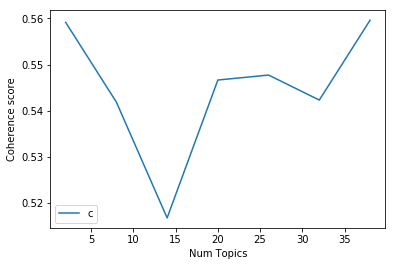

In [23]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5591
Num Topics = 8  has Coherence Value of 0.5418
Num Topics = 14  has Coherence Value of 0.5167
Num Topics = 20  has Coherence Value of 0.5466
Num Topics = 26  has Coherence Value of 0.5477
Num Topics = 32  has Coherence Value of 0.5423
Num Topics = 38  has Coherence Value of 0.5596


In [29]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.017*"iraq" + 0.011*"war" + 0.010*"plan" + 0.009*"iraqi" + 0.007*"call" + '
  '0.007*"fire" + 0.007*"baghdad" + 0.006*"report" + 0.006*"kill" + '
  '0.005*"face"'),
 (1,
  '0.010*"police" + 0.009*"man" + 0.008*"win" + 0.008*"claim" + '
  '0.007*"council" + 0.006*"govt" + 0.006*"urge" + 0.005*"charge" + '
  '0.005*"continue" + 0.005*"court"')]


# Finding the dominant topic in each sentence

In [45]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'headline_text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,headline_text
0,0,0.0,0.5192,"iraq, war, plan, iraqi, call, fire, baghdad, r...","[aba, decide, community, broadcasting, licence]"
1,1,0.0,0.5455,"iraq, war, plan, iraqi, call, fire, baghdad, r...","[act, fire, witness, must, aware, defamation]"
2,2,1.0,0.5185,"police, man, win, claim, council, govt, urge, ...","[call, infrastructure, protection, summit]"
3,3,1.0,0.5185,"police, man, win, claim, council, govt, urge, ...","[staff, aust, strike, pay_rise]"
4,4,1.0,0.5370,"police, man, win, claim, council, govt, urge, ...","[strike, affect, australian, traveller]"
5,5,1.0,0.5091,"police, man, win, claim, council, govt, urge, ...","[ambitious, olsson, win, triple, jump]"
6,6,1.0,0.5091,"police, man, win, claim, council, govt, urge, ...","[antic, delighted, record, break, barca]"
7,7,1.0,0.5179,"police, man, win, claim, council, govt, urge, ...","[aussie, qualifi, stosur, waste, memphis, match]"
8,8,0.0,0.5091,"iraq, war, plan, iraqi, call, fire, baghdad, r...","[aust, address, un_security, council, iraq]"
9,9,0.0,0.5273,"iraq, war, plan, iraqi, call, fire, baghdad, r...","[australia, lock, war, timetable, opp]"


# Find the most representative document for each topic

In [50]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(2)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords","headline_text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,headline_text
0,0.0,0.5614,"iraq, war, plan, iraqi, call, fire, baghdad, r...","[hama, security, chief, kill, west, bank, attack]"
1,0.0,0.5614,"iraq, war, plan, iraqi, call, fire, baghdad, r...","[downer, head, dili, sign, east, timor, gas]"
2,1.0,0.5651,"police, man, win, claim, council, govt, urge, ...","[berri, barmera, council, give, field, day, ro..."
3,1.0,0.5614,"police, man, win, claim, council, govt, urge, ...","[emergency, crew, attend, massive, brisbane, o..."
